# Solving the number partitioning problem using OpenQAOA

## The combinatorial problem

Number partitioning is often considerest the simplest among NP-Hard combinatorial optimisation problems (see [wikipedia](https://en.wikipedia.org/wiki/Partition_problem) for a simple reference). The problem statement is quite simple: you are given a set of numbers $N$ where $n_i \in N$ is a positive integer, and you are asked to find two subsets $A$ and $B$ such that

1. $A \cap B = \emptyset$, i.e., the two sets are disjoint
2. $|\sum_i a_i - \sum_j b_j|$, where $ a \in A$ and $b \in B$ is minimised, i.e., the difference in the sum of all elements in A and the sum of all the elements in B is minimised

Now, QAOA only accepts binary terms. However, we are in luck! There is a straightforward formulation of the above problem statement in binary variables. And it is already implemented in OpenQAOA! :)

\begin{equation}
\verb|Cost function| = (\sum_i n_i x_i)^2
\end{equation}

where each $x_i \in \pm 1$ is a binary decisional variable, and $n_i$ is the i-th number in the list

Let's make a concrete case. Let's assume we want to partition the simples problem we can think of: $N = [1,2,3]$.

Then our cost function will be

\begin{equation}
\verb|Cost function| = (1*x_1 + 2*x_2 + 3*x_3)^2
\end{equation}

Now, our algorithm has to find a set of values $verb|solution| = (x_1, x_2, x_3)$ such that the cost function above is minimised.

For this problem, you can verify that solutions $1,1,0$ and $0, 1, 1$ indeed solve the problem!

# Let's solve the problem with OpenQAOA

### The very first step is the problem creation

In [1]:
from openqaoa.problems.problem import NumberPartition
np = NumberPartition(numbers=[1,2,3])
np_qubo = np.get_qubo_problem()

# Creating device object
from openqaoa.devices import create_device

# Get backend object
from openqaoa.backends.qaoa_backend import get_qaoa_backend

# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = np_qubo.hamiltonian

In [3]:
# You are required to specify a mixer hamiltonian
from openqaoa.utilities import X_mixer_hamiltonian
mixer_hamil = X_mixer_hamiltonian(n_qubits=3)

# Create custom parameters
from openqaoa.qaoa_parameters import create_qaoa_variational_params, QAOACircuitParams
p=1
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil, p=p)

# Creating device object
sim_device = create_device(location='local', name='vectorized')

# Get backend object
sim_backend = get_qaoa_backend(circuit_params, sim_device)

import numpy
def my_submission_function(p):
    """
    Note that the number of betas and gammas depend on the number of layers `p`!

    Also, in OpenQAOA there are several parametrisation techiques which will change the structure 
    of the return of `my_submission_function`
    For more details: https://el-openqaoa.readthedocs.io/en/latest/notebooks/05_advanced_parameterization.html
    
    This function do the following:
    1. Randomly generate betas and gammas for p la
    2. Randomly generate 3 points arround each beta and gammas and each layer
    3. Measure the expectation value for each each beta and gammas and each layer
    4. Get the lowest expectation value for each layer
    """
    for i in range(p):
        #Randomly generated parameters
        params= { 'betas'  : [numpy.random.randn() for i in range(p)],
                  'gammas' : [numpy.random.randn() for i in range(p)]}
        
        # Generate the corners of a triangle inside a circle of radius=1 with center at betas and gammas
        betas_center= params['betas']
        gammas_center=params['gammas']
        
        angles= numpy.array([0,2*numpy.pi/3,4*numpy.pi/3]) + numpy.random.randn()
        b= betas_center + numpy.cos([angles])
        b=b[0]
        g= gammas_center + numpy.sin([angles])
        g=g[0]
        
        expected=[]
        for j in range(3):
            variate_params = create_qaoa_variational_params(circuit_params, 'standard', 'custom', {'betas': b[j], 'gammas': g[j]})
            expected.append( sim_backend.expectation(variate_params) )
        
        #Return the index of the minimum value
        minimum_index = numpy.argmin(expected)
        min_expval = expected[minimum_index]
        
        # Update parameters with minimum value of expectation value
        params= { 'betas'  : b[minimum_index],
                  'gammas' : g[minimum_index]}
        
            
    return params

print(my_submission_function(p))

{'betas': -1.1878788091103751, 'gammas': 0.9331502735380728}


### Now, let's solve the problem using OpenQAOA

In [6]:
from openqaoa.workflows.optimizer import QAOA

The simples QAOA workflow you can crate is the following

In [7]:
# Initialise QAOA using the default values
q = QAOA()
# Complile the QAOA workflow
q.compile(np_qubo)

# Optimise the problem!
q.optimize()

states kept: 8


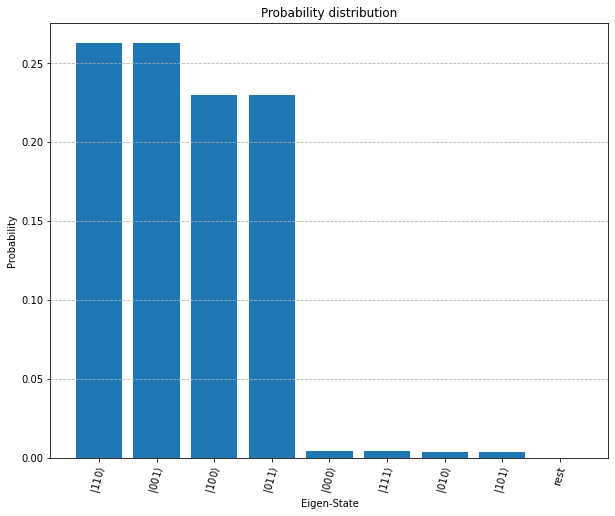

In [8]:
q.results.plot_probabilities()

Yay! Indeed the two states with the highes probabilities are `110` and `110`

## Setting up the initial parmeters

Let's try to set the initial parameters for OpenQAOA

In [13]:
# Initialise QAOA
q = QAOA()
q.compile(np_qubo)

After compiling the problem, OpenQAOA generates and initialises the value of the variational parameters:

In [14]:
q.variate_params

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.35]
	gammas: [0.35]

However, as problems get more and more complex it gets hardwre and harder to select good parameters. In OpenQAOA we have three strategies controlled by the keywordk `init_type`:

1. Random
2. Custom
3. (linear) Ramp

In [17]:
# Initialise QAOA
q = QAOA()
q.set_circuit_properties(p=1, param_type='standard', init_type='rand')
q.compile(np_qubo)

In [18]:
q.variate_params

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [2.0659122]
	gammas: [1.66074957]

## The challenge

You have to find a good way to initialise the variational parameters!

In [19]:
# You are required to specify a mixer hamiltonian
from openqaoa.utilities import X_mixer_hamiltonian
mixer_hamil = X_mixer_hamiltonian(n_qubits=3)

# Create custom parameters
from openqaoa.qaoa_parameters import create_qaoa_variational_params, QAOACircuitParams
p=1
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil, p=p)

# Creating device object
sim_device = create_device(location='local', name='vectorized')

# Get backend object
sim_backend = get_qaoa_backend(circuit_params, sim_device)

import numpy
def my_submission_function(p):
    """
    Note that the number of betas and gammas depend on the number of layers `p`!

    Also, in OpenQAOA there are several parametrisation techiques which will change the structure 
    of the return of `my_submission_function`
    For more details: https://el-openqaoa.readthedocs.io/en/latest/notebooks/05_advanced_parameterization.html
    
    This function do the following:
    1. Randomly generate betas and gammas for p la
    2. Randomly generate 3 points arround each beta and gammas and each layer
    3. Measure the expectation value for each each beta and gammas and each layer
    4. Get the lowest expectation value for each layer
    """
    for i in range(p):
        #Randomly generated parameters
        params= { 'betas'  : [numpy.random.randn() for i in range(p)],
                  'gammas' : [numpy.random.randn() for i in range(p)]}
        
        # Generate the corners of a triangle inside a circle of radius=1 with center at betas and gammas
        betas_center= params['betas']
        gammas_center=params['gammas']
        
        angles= numpy.array([0,2*numpy.pi/3,4*numpy.pi/3]) + numpy.random.randn()
        b= betas_center + numpy.cos([angles])
        b=b[0]
        g= gammas_center + numpy.sin([angles])
        g=g[0]
        
        expected=[]
        for j in range(3):
            variate_params = create_qaoa_variational_params(circuit_params, 'standard', 'custom', {'betas': b[j], 'gammas': g[j]})
            expected.append( sim_backend.expectation(variate_params) )
        
        #Return the index of the minimum value
        minimum_index = numpy.argmin(expected)
        min_expval = expected[minimum_index]
        
        # Update parameters with minimum value of expectation value
        params= { 'betas'  : b[minimum_index],
                  'gammas' : g[minimum_index]}
        
            
    return params

print(my_submission_function(p))

{'betas': -1.9322728333259969, 'gammas': 0.914100115952216}


In [21]:
p = 1
q_submission = QAOA()
q_submission.set_circuit_properties(p=p, 
                                    param_type='standard',
                                    init_type='custom',
                                    variational_params_dict=my_submission_function(p))

In [23]:
my_submission_function(1)

{'betas': 0.7576561944640988, 'gammas': 2.192973967646362}

In [26]:
q_submission.compile(np_qubo)

In [27]:
q_submission.optimize()

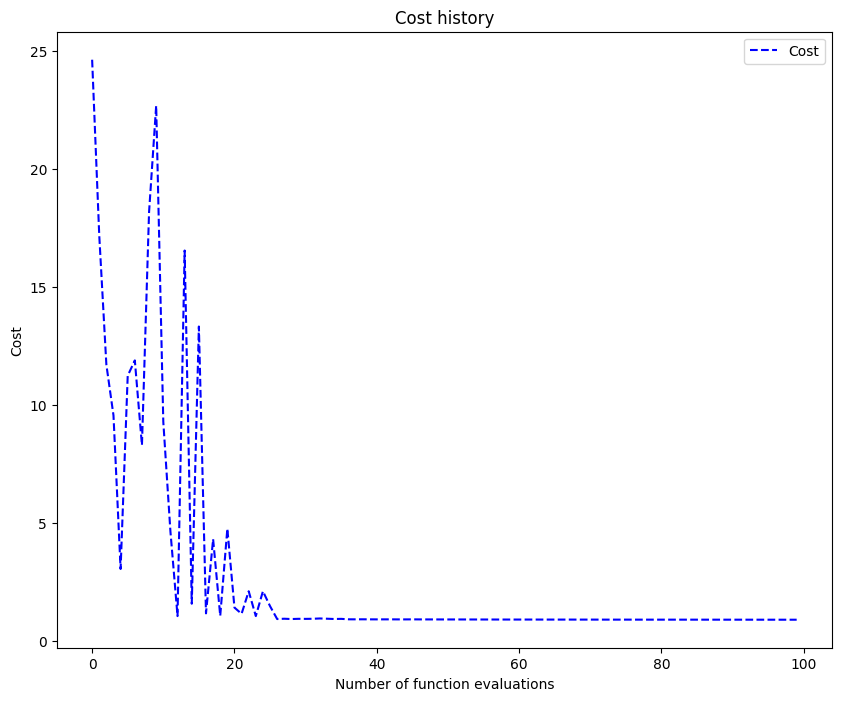

In [28]:
q_submission.results.plot_cost()

states kept: 8


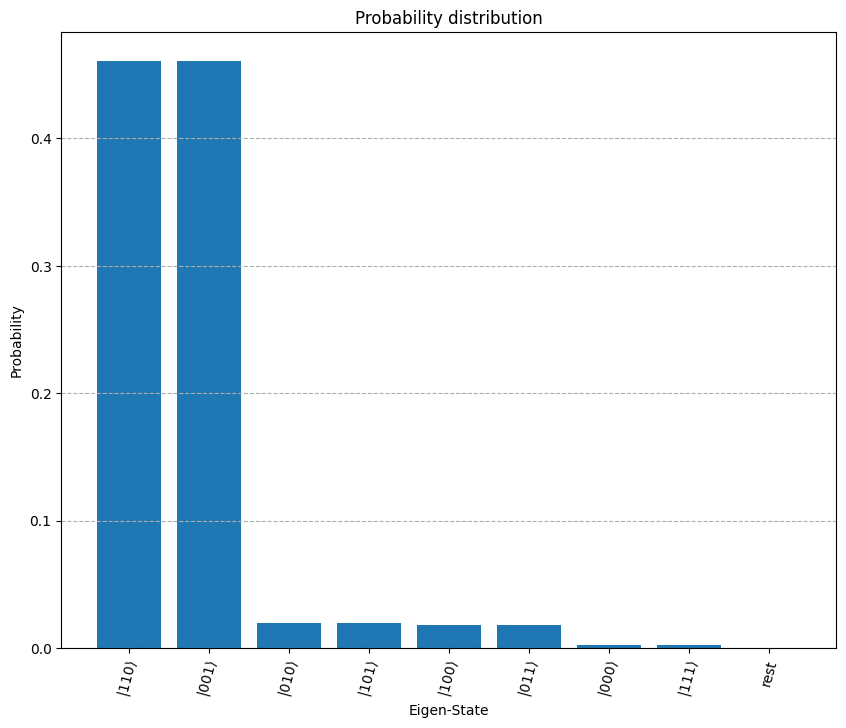

In [29]:
q_submission.results.plot_probabilities()

In [31]:
q_submission.results.optimized

{'optimized angles': [1.66965151740754,
  0.6375614072232378,
  -1.1201697453886026,
  -1.428165484630001],
 'optimized cost': 0.8831835286775866,
 'optimized measurement outcomes': array([-0.03369381-0.03310497j, -0.05957972+0.11899007j,
         0.02484488-0.13735447j,  0.67713975-0.04537234j,
         0.67713975-0.04537234j,  0.02484488-0.13735447j,
        -0.05957972+0.11899007j, -0.03369381-0.03310497j]),
 'optimized run job id': []}

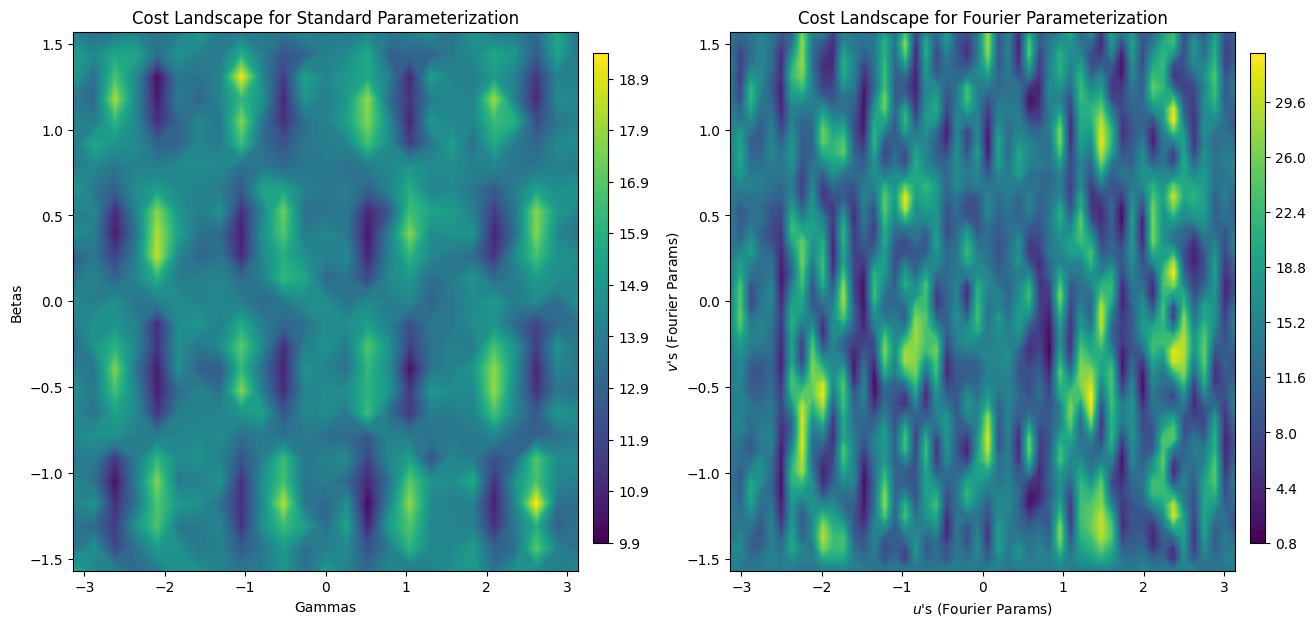

In [32]:
fig,axes = plt.subplots(1,2,sharex = False, sharey=False,figsize=(15,7),gridspec_kw={'wspace': 0.3})
cmap = 'viridis'

im_0 = axes[0].contourf(cost_landscape_std,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[0].set_title('Cost Landscape for Standard Parameterization')
axes[0].set_xlabel('Gammas')
axes[0].set_ylabel('Betas')

cbar_ax = fig.add_axes([0.472, 0.15, 0.01, 0.7])
fig.colorbar(im_0, cax=cbar_ax)

im_1 = axes[1].contourf(cost_landscape_fourier,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[1].set_title('Cost Landscape for Fourier Parameterization')
axes[1].set_xlabel("$u$'s (Fourier Params)")
axes[1].set_ylabel("$v$'s (Fourier Params)")

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im_1, cax=cbar_ax);

## Data generation

To generate data for the number partitioning problem simple generate lists of 10 random numbers between 1 and 30. For example,

In [ ]:
np_input = [numpy.random.randint(30) for i in range(10)]
np_input